# Fake News
### Build a system to identify unreliable news articles

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../input/fake-news/train.csv')

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
df.dropna(inplace=True)

In [6]:
X = df.drop('label',axis=1)
y = df['label']

In [7]:
X.shape, y.shape

((18285, 4), (18285,))

# We Will Use Title for training ...

In [8]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

In [9]:
### Vocabulary size
voc_size=5000

## Onehot Representation

In [11]:
messages=X.copy()

In [12]:
messages.reset_index(inplace=True)

In [13]:
messages

,index,id,title,author,text
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...
...,...,...,...,...,...
18280,20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...
18281,20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...
18282,20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...
18283,20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [14]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [15]:
import nltk
import re
from nltk.corpus import stopwords

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Dataset Preprocessing

In [17]:

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)


In [18]:
# original Text 
messages["title"][:5]

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    FLYNN: Hillary Clinton, Big Woman on Campus - ...
2                    Why the Truth Might Get You Fired
3    15 Civilians Killed In Single US Airstrike Hav...
4    Iranian woman jailed for fictional unpublished...
Name: title, dtype: object

In [19]:
# After doing Text preprocessing 
corpus[:5] 

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri']

In [20]:

onehot_repr=[one_hot(words,voc_size) for words in corpus] 
onehot_repr[:5]

[[1178, 3957, 259, 243, 2694, 1674, 4094, 1657, 3596, 741],
 [720, 2594, 2487, 1808, 2814, 1771, 1483],
 [3822, 2065, 2664, 3229],
 [2932, 746, 4329, 4510, 2344, 4420],
 [2682, 2814, 2581, 298, 376, 950, 2814, 4444, 1119, 4350]]

## Embedding Representation

In [22]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 1657 3596  741]
 [   0    0    0 ... 2814 1771 1483]
 [   0    0    0 ... 2065 2664 3229]
 ...
 [   0    0    0 ... 4471  566 2320]
 [   0    0    0 ... 4541  216 2425]
 [   0    0    0 ... 2206 1279 1620]]


In [23]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1178,
       3957,  259,  243, 2694, 1674, 4094, 1657, 3596,  741], dtype=int32)

## Creating model

In [24]:

embedding_vector_features=40
model=Sequential()

model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))

model.add(LSTM(100))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [25]:
len(embedded_docs),y.shape

(18285, (18285,))

In [26]:
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [27]:
X_final.shape,y_final.shape

((18285, 20), (18285,))

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [29]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 2s 11ms/step - loss: 0.3397 - accuracy: 0.8406 - val_loss: 0.2187 - val_accuracy: 0.9115
Epoch 2/10
192/192 [==============================] - 2s 10ms/step - loss: 0.1497 - accuracy: 0.9406 - val_loss: 0.1897 - val_accuracy: 0.9254
Epoch 3/10
192/192 [==============================] - 1s 7ms/step - loss: 0.1127 - accuracy: 0.9591 - val_loss: 0.2074 - val_accuracy: 0.9201
Epoch 4/10
192/192 [==============================] - 1s 7ms/step - loss: 0.0868 - accuracy: 0.9701 - val_loss: 0.2205 - val_accuracy: 0.9216
Epoch 5/10
192/192 [==============================] - 1s 7ms/step - loss: 0.0707 - accuracy: 0.9759 - val_loss: 0.2471 - val_accuracy: 0.9160
Epoch 6/10
192/192 [==============================] - 1s 7ms/step - loss: 0.0575 - accuracy: 0.9815 - val_loss: 0.2610 - val_accuracy: 0.9017
Epoch 7/10
192/192 [==============================] - 1s 7ms/step - loss: 0.0481 - accuracy: 0.9840 - val_loss: 0.2841 - val_accuracy: 0.9132
Epoc

In [31]:
metrics = pd.DataFrame(model.history.history)

In [32]:
metrics.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

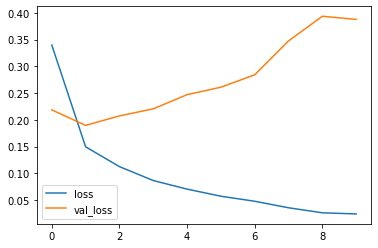

In [33]:
metrics[['loss','val_loss']].plot()

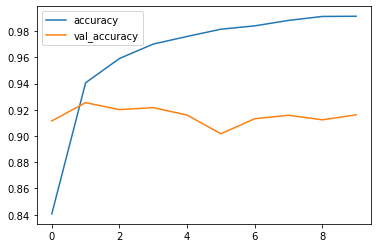

In [34]:
metrics[['accuracy','val_accuracy']].plot()

In [35]:
y_pred=model.predict_classes(X_test)

### Performance Metrics And Accuracy

In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_pred)

array([[3093,  326],
       [ 180, 2436]])

In [ ]:

from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)